In [1]:
import traffic
import pandas as pd 
import os
from traffic.core import Traffic
from biblio_herramienta.herramienta import *
from biblio_herramienta.tratardatos import *

In [2]:
carpetaDatos = r'datos_sectores/' # carpeta que contiene los datos
nombreDatos = "datos_filtrados.csv" 
vuelos = cargardatosfiltrados(carpetaDatos,nombreDatos)
vuelos

count
icao24 callsign       
4ca60f IBK5BV     3683
4cace5 IBK6054    2974
       IBK6055    2343
49514c TAP434M    2175
344495 GES381L    2052
4cacc6 RYR3PE     2036
4853d1 TRA6845    1926
4cabae RYR4Z      1886
3c56f7 EWG4TP     1814
4ca8da RYR6BM     1805

In [3]:
from traffic.data.samples import switzerland
switzerland.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,track,vertical_rate
0,2018-08-01 05:27:30+00:00,34975.0,DLH8JW,443.486933,3003ae,45.818985,9.229546,324.267082,960.0
1,2018-08-01 05:27:40+00:00,35100.0,DLH8JW,442.903670,3003ae,45.832306,9.227645,324.372093,1024.0
2,2018-08-01 05:27:50+00:00,35275.0,DLH8JW,441.508395,3003ae,45.848740,9.210763,324.401979,960.0
3,2018-08-01 05:28:00+00:00,35425.0,DLH8JW,441.508395,3003ae,45.865779,9.193291,324.401979,832.0
4,2018-08-01 05:28:10+00:00,35550.0,DLH8JW,440.695660,3003ae,45.881927,9.176733,324.326300,832.0


In [4]:
switzerland.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139098 entries, 0 to 139097
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   timestamp      139098 non-null  datetime64[ns, UTC]
 1   altitude       139098 non-null  float64            
 2   callsign       139098 non-null  object             
 3   groundspeed    139098 non-null  float64            
 4   icao24         139098 non-null  object             
 5   latitude       139098 non-null  float64            
 6   longitude      139098 non-null  float64            
 7   track          139098 non-null  float64            
 8   vertical_rate  139098 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(2)
memory usage: 9.6+ MB


## Cluster
Se va a intentar clasificar las trayectorias en función de su rumbo. Para eso se va utilziar el método enseñado en traffic

In [5]:
vuelos_un = vuelos.assign_id().unwrap().eval(max_workers=4)
vuelos_un.data.head()

,altitude,callsign,groundspeed,icao24,latitude,longitude,timestamp,track,flight_id,track_unwrapped
0,38000.0,RAM650E,451.0,0200eb,42.346616,-2.903648,2019-02-07 08:22:07+00:00,9.065167,RAM650E_035,9.065167
1,38000.0,RAM650E,451.0,0200eb,42.346616,-2.903648,2019-02-07 08:22:08+00:00,9.065167,RAM650E_035,9.065167
2,38000.0,RAM650E,451.0,0200eb,42.346616,-2.903648,2019-02-07 08:22:09+00:00,9.065167,RAM650E_035,9.065167
3,38000.0,RAM650E,451.0,0200eb,42.354809,-2.901860,2019-02-07 08:22:10+00:00,9.065167,RAM650E_035,9.065167
4,38025.0,RAM650E,451.0,0200eb,42.354809,-2.901860,2019-02-07 08:22:11+00:00,9.065167,RAM650E_035,9.065167


## Aplicación del cluster sobre los datos
La siguiente celda tiene el método de cluster aplicado sobre las trayectorias, una vez computado se genera una columna dentro de los datos que señala el cluster al que pertenece cada trayectoria.
El algoritmo usado el es el DBSCAN

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from traffic.core.projection import CH1903

# la funcion permite aplicar algoritmos de ML a los datos que tenemos
vuelos_dbscan = vuelos_un.clustering(
    nb_samples=15, # divide en 15 puntos las trayecorias
    features=["longitude", "latitude", "track_unwrapped"], # datos cebados al algorimto de ML
    clustering=DBSCAN(eps=0.5, min_samples=10), # algoritmo de ML utilizado, con los parámetros del mismo
    transform=StandardScaler(), # lo que hace esto es escalar los datos dentro de una distribuciñ¡ón Gausiana
).fit_predict()


In [ ]:
vuelos_kmeans = vuelos_un.clustering(
    


)

In [7]:
vuelos_dbscan.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983195 entries, 0 to 983194
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   altitude         983195 non-null  float64            
 1   callsign         983195 non-null  object             
 2   groundspeed      983195 non-null  float64            
 3   icao24           983195 non-null  object             
 4   latitude         983195 non-null  float64            
 5   longitude        983195 non-null  float64            
 6   timestamp        983195 non-null  datetime64[ns, UTC]
 7   track            983195 non-null  float64            
 8   flight_id        983195 non-null  object             
 9   track_unwrapped  983195 non-null  float64            
 10  cluster          983195 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(3)
memory usage: 90.0+ MB


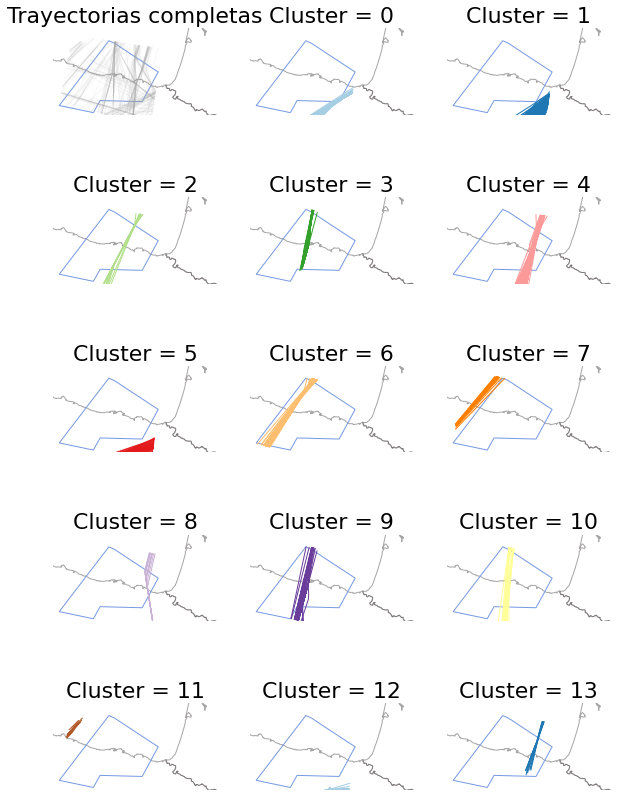

In [8]:
from itertools import islice, cycle
# islice: iterador que itera dentro de una lista, 

from traffic.drawing import countries, EuroPP
from traffic.data import nm_airspaces

n_clusters = 1 + vuelos_dbscan.data.cluster.max() # número de cluster totales

# -- dealing with colours --

color_cycle = cycle(
    "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c "
    "#fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
)
# el métod split hace que se separen l
colors = list(islice(color_cycle, n_clusters)) # asigna colores a los clusters de manera ciclica
        #     islice(valores_de_color,numero_clusters) --> devuelve lista con los colores asignados de
        #                                                  manera cíclica
colors.append("#aaaaaa")  # color for outliers, if any

# -- dealing with the grid --adasd

#nb_cols = 3 # numero de columnas
#nb_lines = (1 + n_clusters) // nb_cols + (((1 + n_clusters) % nb_cols) > 0) # numero de filas en funcion de 
                                                                            # de las columnas

with plt.style.context("traffic"):
    nb_cols = 3 # numero de columnas
    nb_lines = (1 + n_clusters) // nb_cols + (((1 + n_clusters) % nb_cols) > 0) # numero de filas en funcion de 
                                                                                # de las columnas
    fig, ax = plt.subplots(
        nb_lines, nb_cols, figsize=(10, 15), subplot_kw=dict(projection=EuroPP())
        # parametros de la figura y de los ejes
    )
    
    for cluster in range(-1, n_clusters):
        ax_ = ax[(cluster + 1) // nb_cols][(cluster + 1) % nb_cols]
        ax_.add_feature(countries())
        nm_airspaces['LECMBLU'].plot(ax_,alpha = 1)
        
        vuelos_dbscan.query(f"cluster == {cluster}").plot(
            ax_, color=colors[cluster], alpha=0.1 if cluster == -1 else 1
        )
        # la funcion de arriba busca la asginación de cluster
        ax_.set_global()
        ax_.set_extent((-6,0, 42.7, 44.5))
        if cluster == -1:
            ax_.title.set_text("Conjunto")
        else:
            ax_.title.set_text("Cluster = " +str(cluster) )

    guardarimagen("imagenes_cluster","cluster_dbscan.png")         